# Perform Manders's colocalization of MSSR using circular ROIs 

It runs over the data created with the oib2ome-zarr.ipynb.

It restricts the analysis to a order type.

Taylored to work with circular ROIs.

## Install Libraries

In [1]:
print("Installing necessary libraries...")
!pip install ome-zarr PyQt5 napari[all] > /dev/null 2>&1
!pip install git+https://github.com/RoccoDAnt/napari-superres.git > /dev/null 2>&1
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Import libraries

In [2]:
import zarr
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian
from napari_superres.core_mssr import mssr_class
mssr_instance = mssr_class()

/opt/conda/lib/python3.11/site-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "
/opt/conda/lib/python3.11/site-packages/liquid_engine/__opencl__.py:125: UserWarning: tap... tap... tap... COMPUTER SAYS NO (OpenCL)!
  warnings.warn("tap... tap... tap... COMPUTER SAYS NO (OpenCL)!")


This exception is what's causing cl equals None: clGetPlatformIDs failed: PLATFORM_NOT_FOUND_KHR
Cupy implementation is not available. Make sure you have the right version of Cupy and CUDA installed.
Optional dependecy Dask_image is not installed. Implementations using it will be ignored.


## Define File Paths

In [3]:
directory_path = '/home/jovyan/LNMA/bravoa/data/Seleccion ROIs circulares RE'
#ome_zarr_name = '1_Cry11_2mg_2h_RE_2mM_ant_60X_Z3.5_2.zarr'
ome_zarr_name = '7_Cry11_2mg_2h_RE_2mM_ant_60X_Z3.5_bis_bis_2.zarr'
ome_zarr_path = os.path.join(directory_path, ome_zarr_name)
ome_zarr_path

'/home/jovyan/LNMA/bravoa/data/Seleccion ROIs circulares RE/7_Cry11_2mg_2h_RE_2mM_ant_60X_Z3.5_bis_bis_2.zarr'

## Define Parameters

In [4]:
# # folder_path = wd + 'colocaliz-Manders-ER'
# folder_path = wd +  'New Fig para colocalizacion Manders-ER'
order_types = ['VExt']
ch_m1 = 2
ch_m2 = 1
# nameForPDFs = 'Toxin_vs_ER'


### Parameters for MSSR

fwhm = 8  # Full Width at Half Maximum
amp = 1  # Amplitude
order = 1  # Order
mesh = True  # Optional, default is True
ftI = False  # Optional, default is False
intNorm = False  # Optional, default is True
sigma = 2 # For the Gassian filter
visualization_percentiles=(2.5, 97.5)

## Define Functions

In [5]:
# Extract the rectangular region from the specified channel
def extract_rect_roi(image, left, top, width, height):
    return image[top:top+height, left:left+width]

# Extract the oval region from the image, covering the full image dimensions
def extract_oval_roi_from_image(image):
    # Get image dimensions
    height, width = image.shape
    
    # Calculate the center of the oval
    cx, cy = width // 2, height // 2
    
    # Generate a coordinate grid based on the image dimensions
    y, x = np.ogrid[:height, :width]
    
    # Create the oval mask centered within the full image
    mask = ((x - cx) ** 2) / (width / 2) ** 2 + ((y - cy) ** 2) / (height / 2) ** 2 <= 1
    
    # Apply the mask to the image
    oval_roi = np.where(mask, image, 0)
    
    return oval_roi

def manders_colocalization(image1, image2):
    overlap = np.logical_and(image1 > 0, image2 > 0)
    m1 = np.sum(overlap) / np.sum(image1 > 0) if np.sum(image1 > 0) > 0 else 0
    m2 = np.sum(overlap) / np.sum(image2 > 0) if np.sum(image2 > 0) > 0 else 0
    return m1, m2
    
def normalize_channel(channel, lower_percentile, upper_percentile):
    lower_bound = np.percentile(channel, lower_percentile)
    upper_bound = np.percentile(channel, upper_percentile)
    channel = np.clip(channel, lower_bound, upper_bound)
    # Avoid division by zero
    if upper_bound == lower_bound:
        return np.zeros_like(channel)
    return (channel - lower_bound) / (upper_bound - lower_bound)

## Load the OME-Zarr file

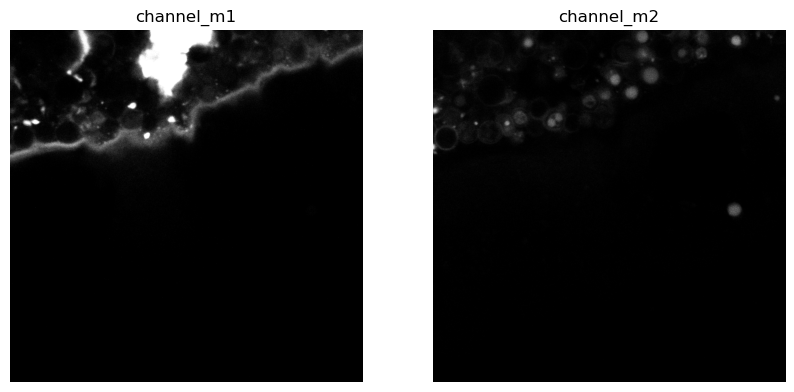

In [6]:
images = zarr.open(ome_zarr_path, mode="r")
channel_m1 = images["image_data"][0, ch_m1, 0, :, :].astype(np.float32)
channel_m2 = images["image_data"][0, ch_m2, 0, :, :].astype(np.float32)

# Set up the figure with two subplots
plt.figure(figsize=(10, 5))

# Display the first image
plt.subplot(1, 2, 1)
plt.title("channel_m1")
plt.imshow(channel_m1, cmap="gray")
plt.axis('off')

# Display the second image
plt.subplot(1, 2, 2)
plt.title("channel_m2")
plt.imshow(channel_m2, cmap="gray")
plt.axis('off')

# Show the figure
plt.show()

## Extract ROI metadata from the OME-Zarr file

In [7]:
roi_metadata = images.attrs.get("roi_metadata", {})
roi_metadata = [item for item in roi_metadata if any(order_type in item['name'] for order_type in order_types)]

# Assuming roi_metadata is a list of dictionaries with each ROI's information
roi_names = [roi.get('name') for roi in roi_metadata]

# Print all ROI names
for i, roi_name in enumerate(roi_names):
    print(f"ROI {i} Name:", roi_name)

ROI 0 Name: 0002-0259-0253-VExt
ROI 1 Name: 0002-0316-0040-VExt
ROI 2 Name: 0002-0264-0350-VExt
ROI 3 Name: 0002-0025-0884-VExt
ROI 4 Name: 0002-0069-0780-VExt
ROI 5 Name: 0002-0212-0456-VExt


## Process each .roi file

In [8]:
#roi_metadata

progress: 100%|██████████| 9/9 [00:00<00:00, 3089.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ROI Name: 0002-0259-0253-VExt
Manders' colocalization coefficients M1 = 0.733, M2 = 0.733


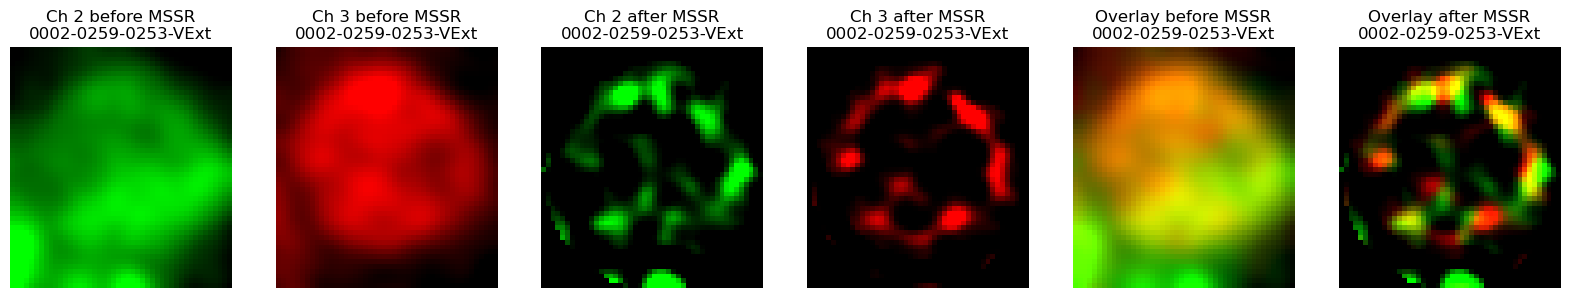

progress: 100%|██████████| 9/9 [00:00<00:00, 1572.01it/s]


ROI Name: 0002-0316-0040-VExt
Manders' colocalization coefficients M1 = 0.509, M2 = 0.472


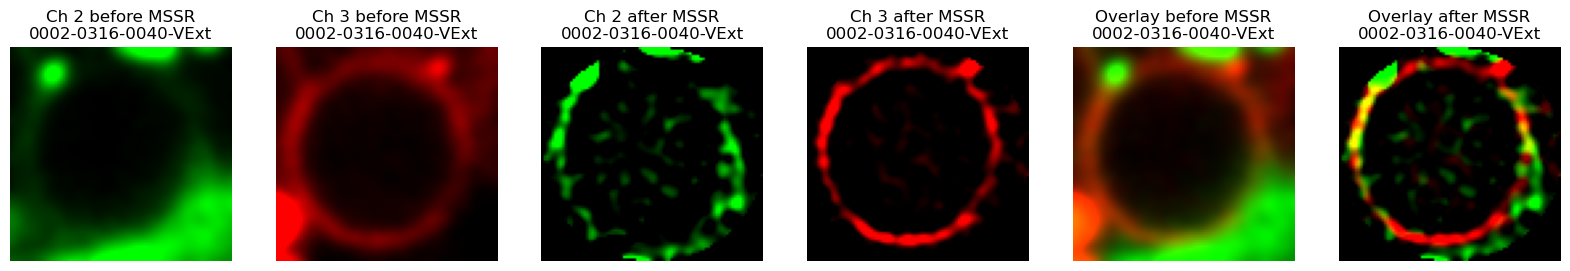

progress: 100%|██████████| 9/9 [00:00<00:00, 1595.60it/s]


ROI Name: 0002-0264-0350-VExt
Manders' colocalization coefficients M1 = 0.659, M2 = 0.605


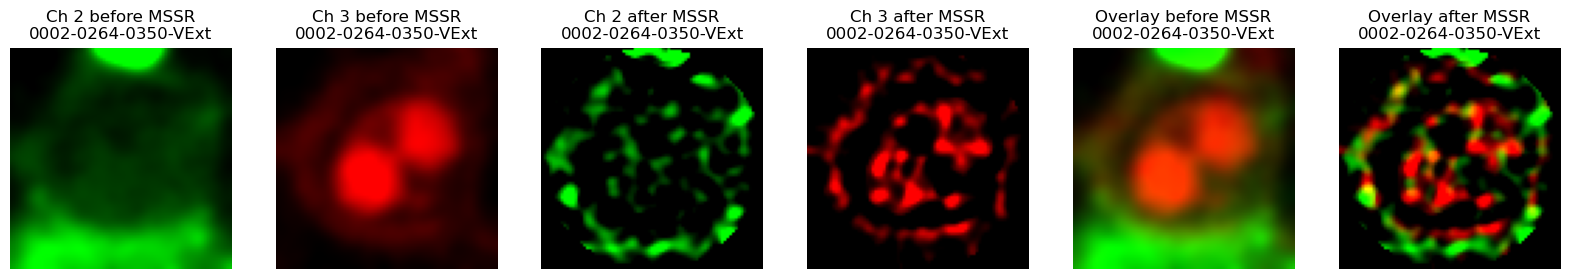

progress: 100%|██████████| 9/9 [00:00<00:00, 2155.22it/s]


ROI Name: 0002-0025-0884-VExt
Manders' colocalization coefficients M1 = 0.576, M2 = 0.599


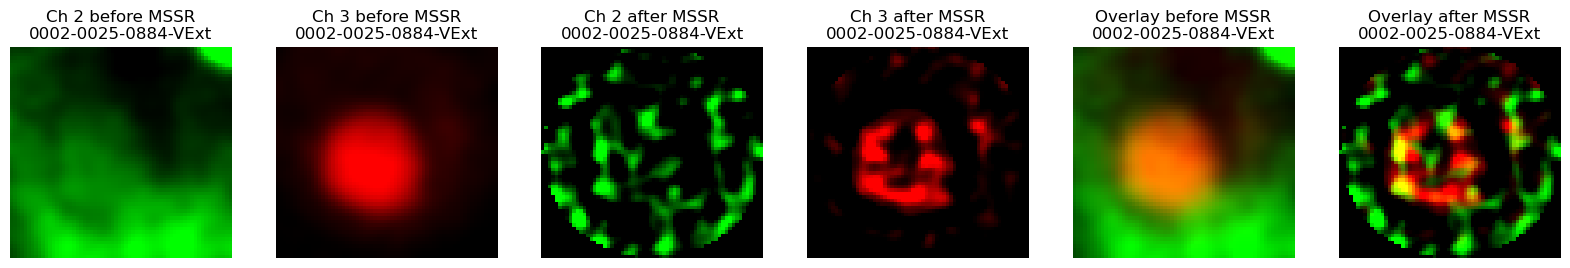

progress: 100%|██████████| 9/9 [00:00<00:00, 3329.99it/s]


ROI Name: 0002-0069-0780-VExt
Manders' colocalization coefficients M1 = 0.785, M2 = 0.754


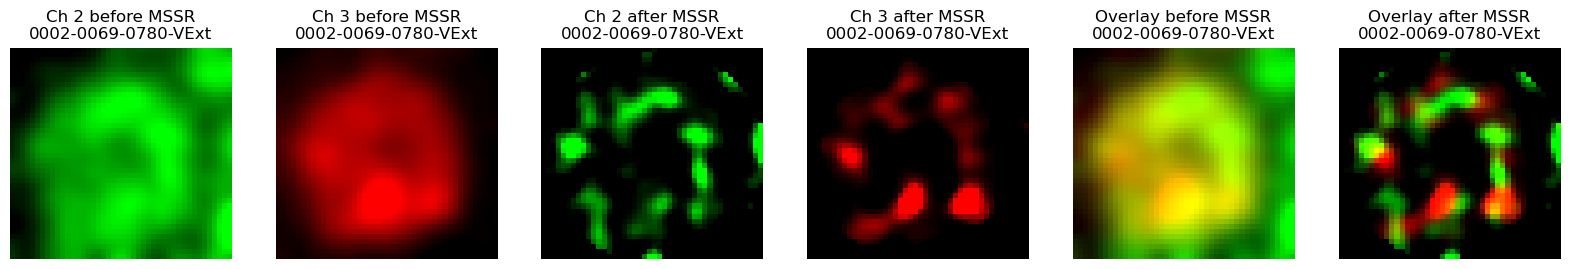

progress: 100%|██████████| 9/9 [00:00<00:00, 2961.61it/s]


ROI Name: 0002-0212-0456-VExt
Manders' colocalization coefficients M1 = 0.643, M2 = 0.636


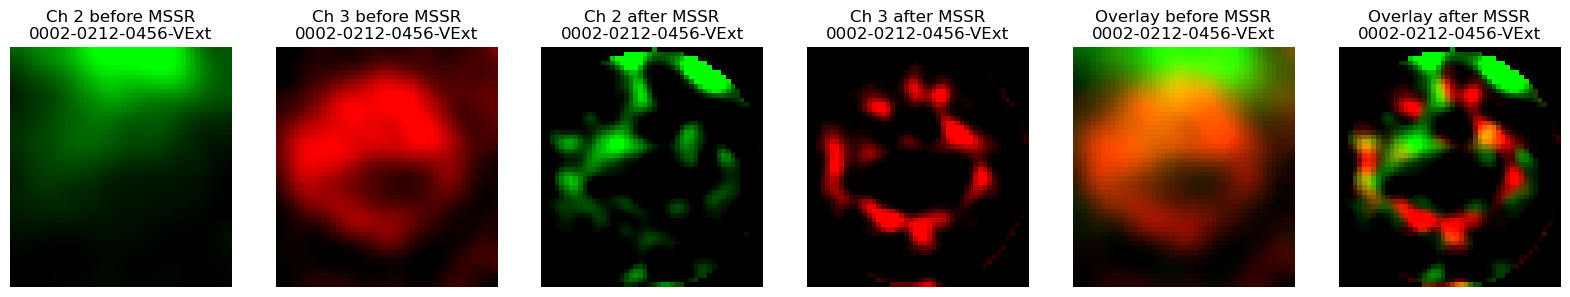

In [9]:
M = []

for roi_info in roi_metadata:

    left = roi_info['left']
    if(left < 0):
        left = 0
    top = roi_info['top']
    if(top < 0):
        top = 0
    width = roi_info['width']
    height = roi_info['height']

    # Extract ROIs
    roi_channel_m1 = extract_rect_roi(channel_m1, left, top, width, height)
    roi_channel_m2 = extract_rect_roi(channel_m2, left, top, width, height)
    
    # Apply Gaussian filter
    roi_channel_m1 = gaussian(roi_channel_m1, sigma)
    roi_channel_m2 = gaussian(roi_channel_m2, sigma)

    # Apply MSSR
    roi_channel_m1_mssr = mssr_instance.sfMSSR(img=roi_channel_m1,
                                               fwhm=fwhm, amp=amp,
                                               order=order,
                                               mesh=mesh, ftI=ftI,
                                               intNorm=intNorm)
    
    roi_channel_m2_mssr = mssr_instance.sfMSSR(img=roi_channel_m2,
                                               fwhm=fwhm, amp=amp,
                                               order=order,
                                               mesh=mesh, ftI=ftI,
                                               intNorm=intNorm)
    if(roi_info['type']=='oval'):
        roi_channel_m1_mssr = extract_oval_roi_from_image(roi_channel_m1_mssr)
        roi_channel_m2_mssr = extract_oval_roi_from_image(roi_channel_m2_mssr)

    # Compute Manders' colocalization coefficients after MSSR
    m1, m2 = manders_colocalization(roi_channel_m1_mssr, roi_channel_m2_mssr)

    # Append the results as a tuple
    M.append((roi_info['name'], round(m1, 3), round(m2, 3)))
    
    print(f"ROI Name:", roi_info['name'])
    print(f"Manders' colocalization coefficients M1 = {round(m1, 3)}, M2 = {round(m2, 3)}")

    norm_channel_m1 = normalize_channel(roi_channel_m1, visualization_percentiles[0], visualization_percentiles[1])
    norm_channel_m2 = normalize_channel(roi_channel_m2, visualization_percentiles[0], visualization_percentiles[1])
    norm_channel_m1_mssr = normalize_channel(roi_channel_m1_mssr, visualization_percentiles[0], visualization_percentiles[1])
    norm_channel_m2_mssr = normalize_channel(roi_channel_m2_mssr, visualization_percentiles[0], visualization_percentiles[1])

    # Create RGB images
    green_channel_m1 = np.zeros((roi_channel_m1.shape[0], roi_channel_m1.shape[1], 3), dtype=float)
    red_channel_m2 = np.zeros((roi_channel_m2.shape[0], roi_channel_m2.shape[1], 3), dtype=float)
    green_channel_m1_mssr = np.zeros((roi_channel_m1_mssr.shape[0], roi_channel_m1_mssr.shape[1], 3), dtype=float)
    red_channel_m2_mssr = np.zeros((roi_channel_m2_mssr.shape[0], roi_channel_m2_mssr.shape[1], 3), dtype=float)

    green_channel_m1[..., 1] = norm_channel_m1  # Channel 2 in green
    red_channel_m2[..., 0] = norm_channel_m2    # Channel 3 in red
    green_channel_m1_mssr[..., 1] = norm_channel_m1_mssr  # Channel 2 in green after MSSR
    red_channel_m2_mssr[..., 0] = norm_channel_m2_mssr    # Channel 3 in red after MSSR

    # Display the results in a single row
    plt.figure(figsize=(20, 5))

    # Display the original images with adjusted brightness and contrast
    plt.subplot(1, 6, 1)
    plt.title(f"Ch 2 before MSSR\n{roi_info['name']}")
    plt.imshow(green_channel_m1)
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.title(f"Ch 3 before MSSR\n{roi_info['name']}")
    plt.imshow(red_channel_m2)
    plt.axis('off')

    # Display the images after MSSR with adjusted brightness and contrast
    plt.subplot(1, 6, 3)
    plt.title(f"Ch 2 after MSSR\n{roi_info['name']}")
    plt.imshow(green_channel_m1_mssr)
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.title(f"Ch 3 after MSSR\n{roi_info['name']}")
    plt.imshow(red_channel_m2_mssr)
    plt.axis('off')

    # Display overlay of both channels before MSSR
    combined_before = np.zeros((roi_channel_m1.shape[0], roi_channel_m1.shape[1], 3), dtype=float)
    combined_before[..., 1] = norm_channel_m1  # Channel 2 in green component
    combined_before[..., 0] = norm_channel_m2  # Channel 3 in red component

    plt.subplot(1, 6, 5)
    plt.title(f"Overlay before MSSR\n{roi_info['name']}")
    plt.imshow(combined_before)
    plt.axis('off')

    # Display overlay of both channels after MSSR
    combined_after = np.zeros((roi_channel_m1_mssr.shape[0], roi_channel_m1_mssr.shape[1], 3), dtype=float)
    combined_after[..., 1] = norm_channel_m1_mssr  # Channel 2 in green component
    combined_after[..., 0] = norm_channel_m2_mssr  # Channel 3 in red component

    plt.subplot(1, 6, 6)
    plt.title(f"Overlay after MSSR\n{roi_info['name']}")
    plt.imshow(combined_after)
    plt.axis('off')

    plt.show()


In [10]:
M

[('0002-0259-0253-VExt', 0.733, 0.733),
 ('0002-0316-0040-VExt', 0.509, 0.472),
 ('0002-0264-0350-VExt', 0.659, 0.605),
 ('0002-0025-0884-VExt', 0.576, 0.599),
 ('0002-0069-0780-VExt', 0.785, 0.754),
 ('0002-0212-0456-VExt', 0.643, 0.636)]